
---
Supervised learning algorithm Decision Trees on Credit Card Transactions
---



### **Overview**
The following code splits the data 80/20. 80% is the training and 20% is validation. This decision tree algorithm takes the best threshold and best feature in order to make the tree. Precision, Accuracy, F1 Score, and Recall are calculated and printed out at the end. 

### **Setting up classes and functions**
The following cell sets up the class Point in order to set up each transaction to have all of the features.  


In [ ]:
#@title
class Point:
    def __str__(self):
        return "<{}:{}>".format(self.label, self.values)
    def __repr__(self):
        return "<{}:{}>".format(self.label, self.values)
    def __init__(self, label, values):
        self.label = label
        self.values = values



The following cell creates the class Tree in order to create the decision tree. The functions predict, accuracy, precision, F1 Score, and Recall are all created here.  

In [ ]:
#@title
from math import log
import pickle as pkl
import matplotlib. pyplot as plt
class Tree:
    leaf = True
    prediction = None
    feature = None
    threshold = None
    left = None
    right = None

def predict(tree, point):
    if tree.leaf:
        return tree.prediction
    i = tree.feature
    if (point.values[i] < tree.threshold):
        return predict(tree.left, point)
    else:
        return predict(tree.right, point)

def most_likely_class(prediction):
    labels = list(prediction.keys())
    probs = list(prediction.values())
    return labels[probs.index(max(probs))]

def accuracy(data, predictions):
    total = 0
    correct = 0
    for i in range(len(data)):
        point = data[i]
        pred = predictions[i]
        total += 1
        guess = most_likely_class(pred)
        if guess == point.label:
            correct += 1
    return float(correct) / total

def precision(data, predictions):
    true_positives = 0
    pred_positives = 0
    for i in range(len(data)):
      point = data[i]
      pred = predictions[i]
      guess = most_likely_class(pred)
      if(point.label == 'is_fraud' and point.label == guess):
        true_positives += 1
    for j in range(len(data)):
      point = data[j]
      pred = predictions[j]
      guess = most_likely_class(pred) 
      if(point.label == 'not_fraud' and guess == 'is_fraud'):
        pred_positives += 1
    return float(true_positives/(true_positives + pred_positives))

def F1_Score(recall, precision):
  denominator = (1/recall) + (1/precision)
  return float(2 * (1/denominator))


def Recall(data, predictions):
  true_positives = 0
  pred_positives = 0
  for i in range(len(data)):
    point = data[i]
    pred = predictions[i]
    if(point.label == 'is_fraud' and point.label == most_likely_class(pred)):
      true_positives += 1
  for j in range(len(data)):
    point = data[j]
    pred = predictions[j]
    if(point.label == 'is_fraud' and most_likely_class(pred) == 'not_fraud'):
      pred_positives += 1
  return float(true_positives/(true_positives + pred_positives))


In [ ]:
def split_data(data, feature, threshold):
    left = []
    right = []
    #I am using a for loop to iterate through all the elements in the data
    for i in range(len(data)):
        #if the data value for that specific feature is less than the threshold then the full
        #data is added to the left. I am using append to add the data since left is a list
        if(data[i].values[feature] < threshold):
            left.append(data[i])
        else:
            #if the data value for that specific feature is greater than or equal to the threshold
            #then the full data is added to the right. I am using append to add the data to the right since it is a list
            right.append(data[i])
    #returning both left and right lists
    return (left, right)

### **Creating functions to count the labels and calculate entropy**

The count_labels function returns the number of times each label has occured. The function counts_to_entropy returns the entropy at each point using the following formula. 
 $H(X) = -\sum_{i} P(X=i) \log_2 P(X=i)$

In [ ]:
def count_labels(data):
    counts = {}
    #using a for loop to iterate through the data
    #not using the length of the data because I have researched for loops in python 
    #and a for loop works just the same without the length
    for point in data:
        #if the label of the specific element in data is in the dictionary counts
        #using the key function to help since it goes through count and gets the keys for me
        if(point.label in counts.keys()):
              #if the label is in count then the value of for that label is increased
              counts[point.label] += 1
        else:
              #if it is not then the label is created and set to 1
              counts[point.label] = 1
    #returning counts
    return counts

def counts_to_entropy(counts):
    entropy = 0.0
    #creaing an index list to hold all of the values in count for each label
    index_list = list(counts.values())
    #if the length of the list is 0 then there are no elements and the entropy is 0.0
    if(len(index_list) == 0):
        entropy = 0.0
    else:
      #creating a variable to hold the total of the sum of the values in counts
      total = 0.0
      #using a for loop to go through each value in counts
      for index in counts.values():
          #adding the value to the total
          total += index
      #using a for loop to go through each value in counts again
      for value in counts.values():
          #calculating the probability using the formula found in the lecture slides
          probability = value / total
          #if the probability is 0 then that means that the value is 0
          if(probability == 0.0):
            #the entropy is then 0
            entropy = 0.0
          else:
            #if the probability is not 0 then the entropy is calculated using the
            #formula from the lecture slides. It is then added to the previous entropy since
            #entropy is the addition of the entropy of all the values
            entropy += (-1) * (probability * log(probability,2))
    #returning the entropy 
    return entropy

In [ ]:
#@title
def get_entropy(data):
    counts = count_labels(data)
    entropy = counts_to_entropy(counts)
    return entropy

### **Determining the best threshold**

The function find_best_threshold_fast takes the data and sorts it based on the feature. It then goes through the data to see which point of data produces the best gain and best threshold. 



In [ ]:
def find_best_threshold_fast(data, feature):
    entropy = get_entropy(data)
    best_gain = 0
    best_threshold = None
                    
    #using the function sorted and specifying the feature and value to sort by
    #this makes running the code faster

    data = sorted(data, key= lambda x:x.values[feature])

    #At first I used a for loop to copy the data over but then it was running to slow 
    #so I switched to using the copy method
    
    right = data.copy()
    #for i in range(len(data)):
    #    right.append(data[i])
    #creating a list left and setting it to empty
    left = []
    #creating a list counts right that will hold all of the labels in the data
    counts_right = count_labels(right)
    #creating a counts left to hold the labels that will be added
    counts_left = {}
    #using a for loop to go though each point in data
    for point in data:
        #I at first used get_entropy to find the data but then when I ran it it took too long
        #and was getting stuck in count labels so I had to change it
        #curr = (get_entropy(left)*len(left) + get_entropy(right)*len(right))/len(data)
        #getting the entropy of the data in left
        entropy_left = counts_to_entropy(counts_left)
        #getting the entropy in right
        entropy_right = counts_to_entropy(counts_right)
        #calculating the curr which is the total entropy 
        curr = (entropy_left*len(left) + entropy_right*len(right))/len(data)
        #calculating the gain by subtracting curr from entropy
        gain = entropy - curr
        #if the gain is greater than the best gain  
        if gain > best_gain:
            #the best gain becomes the gain
            best_gain = gain
            #the best threshold becomes the value of that specific feature
            best_threshold = point.values[feature]
        #the next segmant of code was written using the pesudocode provided in the directions
        #the point is then added to the left
        left.append(point)
        #the point is then removd from the right
        right.remove(point)
        #creating a boolean to hold if the label is already in the counts left or counts right
        label_there = False
        #getting all the keys in counts left
        left_keys = counts_left.keys()
        #getting all the keys in counts right
        right_keys = counts_right.keys()
        #getting the label of the element in data that the for loop is on
        key = point.label
        #creating a boolean to see if the counts left or right is empty
        empty = False
        #if the length of counts left is 0 then it is empty and 
        #empty is set to true
        if(len(counts_left) == 0):
            empty = True  
        elif(label_there == False):
            #if the label there is false then it means that the point label needs
            #to be checked to see if it is in left or right
            #using an if statement to see if the label is in counts left
            if key in left_keys:
                #if it is then the label there is set to true
                label_there = True
                #the value of the label in counts label is increased by 1
                counts_left[point.label] += 1
        #if the label is not in counts left or counts left is empty
        if(label_there == False or empty == True):
            #create a new label in counts left and set its value to 1
            counts_left[point.label] = 1 
        #if the label is in counts right then decrease the value of the label by 1
        if key in right_keys:
            counts_right[point.label] -= 1  
        
   
    #returning the best gain and best threshold
    return (best_gain, best_threshold)

### **Determining the best split**

The function find_best_split goes through each point in the data and determines which feature has the best gain and best threshold. 

In [ ]:
def find_best_split(data):
    if len(data) < 2:
        return None, None
    best_feature = None
    best_threshold = None
    best_gain = 0
    #using a for loop to go through each feature. Using the first data point
    #since all the data points have the same number of features
    for index in range(len(data[0].values)):
      #calling best_threshold_fast to get the best threshold and best gain
       best_gain_i, best_threshold_i = find_best_threshold_fast(data, index)
       #if the gain is 0 then there is no best gain so best gain is none
       #best threshold is none and best feature is none
       if(best_gain_i == 0):
         best_gain = None
         best_threshold = None
         best_feature = None
       elif(best_gain_i > best_gain):
         #if the best gain of the feature is greater than the best_gain
         #that best feature, gain and threshold become the best gain feature and threshold 
         best_gain = best_gain_i
         best_threshold = best_threshold_i
         best_feature = index
       elif(best_gain_i == best_gain):
         #if the best gain of the feature is  equal to the best_gain
         #that best feature, gain and threshold become the best gain feature and threshold 
         best_gain = best_gain_i
         best_threshold = best_threshold_i
         best_feature = index

    #returning the best feature and best threshold
    return (best_feature, best_threshold)

### **Implementing c45 algorithm**###

The following functions implement the c45 algorithm. Instead of only splitting the data 80/20 at the begining the c45 algorithm keeps splitting the data until there is no best gain. 

In [ ]:
def make_leaf(data):
    tree = Tree()   
    counts = count_labels(data)
    prediction = {}
    for label in counts:
        prediction[label] = float(counts[label])/len(data)
    tree.prediction = prediction
    return tree

def c45(data, max_levels):
    if max_levels <= 0:
        return make_leaf(data)

    #if the maximum level depth is reached has been taken care of with the if statement above
    #If all the points have the same label, then make a leaf with the data
    #first checking to see if the data has all the same labels
    #creating an empty list
    label_list = []
    #using a for loop to go through each element in the data
    for i in range(len(data)):
        #if the length of the list is 0 then nothing is in there and the label is added
        if(len(label_list) == 0):
            label_list.append(data[i].label)
        elif(len(label_list) == 1):
          #if the list only has one label checking to see if the data label is not the same
          #if it is not then adding it to the list
            if(data[i].label != label_list[0]):
                label_list.append(data[i].label)
        elif(len(label_list) == 2):
            #if the list has two labels checking to see if the data label is not the same
            #if it is not then adding it to the list
            if(data[i].label != label_list[0] and data[i].label != label_list[1]):
                label_list.append(data[i].label)
    
    #if the list only has one label then that means the data has the same labels
    #a leaf is then made
    if(len(label_list) == 1):
        return make_leaf(data) 
    #in order to see if no split results in further gain the best feature and best threshold
    #need to be found
    best_feature, best_threshold = find_best_split(data)
    #if there is no best feature or best threshold then make a leaf
    if(best_feature == None and best_threshold == None):
        return make_leaf(data)
    else:
        #if the best feature and best threshold are found then split the data
        left, right = split_data(data, best_feature, best_threshold)
        #making a tree
        Make_tree = Tree()
        #setting the leaf to false  in order to Make an internal (non-leaf) node for that feature and threshold.
        Make_tree.leaf = False
        #setting the trees feature and threshold to the best feature and threshold
        Make_tree.feature = best_feature
        Make_tree.threshold = best_threshold
        #Creating the left and right subtrees of the node by recursing on the two partitions of the data.
        #setting the max_leves to max_levels -1 in order to eventually reach 0
        Make_tree.left = c45(left, max_levels - 1)
        Make_tree.right = c45(right, max_levels - 1)
    #returning the tree created
    return Make_tree

### **Testing the data**

The data contains about 2,000 transactions with half being fraudulent and the other half being infraudulent. The data is normalized.



In [ ]:
def testing(train, test, levels):
    tree = c45(train,levels)
    predictions = []
    
    for point in test:
        predictions.append(predict(tree, point))
    
    return predictions

# This might be useful for debugging.
def print_tree(tree):
    if tree.leaf:
        print("Leaf", tree.prediction)
    else:
        print("Branch", tree.feature, tree.threshold)
        print_tree(tree.left)
        print_tree(tree.right)

### **Gathering Dataset**
The dataset is loaded through google drive. The dataset was converted to all numbers prior to being loaded and then normalized. 

In [ ]:
import sys
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

new_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Normalized_data.csv')
from sklearn import preprocessing
scale = preprocessing.MinMaxScaler()
col = new_data.columns
result = scale.fit_transform(new_data)
df = pd.DataFrame(result, columns = col)
train, test = train_test_split(df, test_size=0.2)
array = []
for i in train['is_fraud'].keys():
  if(train['is_fraud'][i] == 1.0):
    label = 'is_fraud'
  else:
    label = 'not_fraud'
  array2 = []
  for j in train.keys():
    if(j == 'merch_long' or j == 'merch_lat' or j == 'job' or j == 'city_pop' or j == 'long' or j == 'lat' or j == 'zip' or j == 'state' or j == 'street' or j == 'last' or j == 'first' or j == 'amt'or j == 'category' or j == 'merchant' or j == 'city' or j == 'dob'):
      array2.append(train[j][i])
    
  array.append(Point(label, array2))

train = array.copy()
fp_train = train

array = []
for i in test['is_fraud'].keys():
  if(test['is_fraud'][i] == 1.0):
    label = 'is_fraud'
  else:
    label = 'not_fraud'
  array2 = []
  for j in test.keys():
    if(j == 'merch_long' or j == 'merch_lat' or j == 'job' or j == 'city_pop' or j == 'long' or j == 'lat' or j == 'zip' or j == 'state' or j == 'street' or j == 'last' or j == 'first' or j == 'amt' or j == 'category' or j == 'merchant'or j == 'city' or j == 'dob'):
      array2.append(test[j][i])
    
  
  array.append(Point(label, array2))

test = array.copy()
fp_valid = test



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


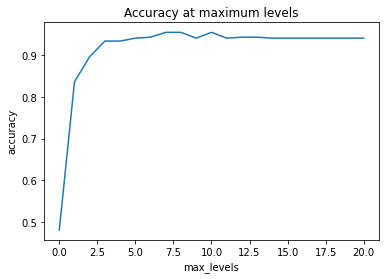

Accuracy is:0.9557109557109557
Precision is:0.9594594594594594
Recall is:0.9551569506726457
F1_Score is:0.957303370786517


In [ ]:
def test_data(fp_train, fp_valid):
    train = fp_train
    valid = fp_valid
    
    a_list = []
    x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    for l in range(21):
      preds = testing(train, valid, l)
      acc = accuracy(valid, preds)
      a_list.append(acc)
    plt.plot(x, a_list)
    plt.title('Accuracy at maximum levels')
    plt.xlabel('max_levels')
    plt.ylabel('accuracy')
    plt.show()
    
    m = max(a_list)
    i = a_list.index(m)
    
    preds = testing(train, valid, x[i])
    acc = accuracy(valid, preds)
    print("Accuracy is:{}".format(acc))
    prec = precision(valid, preds)
    print("Precision is:{}".format(prec))
    recall = Recall(valid, preds)
    print("Recall is:{}".format(recall))
    f1score = F1_Score(recall, prec)
    print("F1_Score is:{}".format(f1score))
    
   
test_data(fp_train, fp_valid)


### **Acknowledgments**###
This algorithm of decision trees was adapted using the ECE 4424 course Homework 1. 


